## Imports and custom class definitions

In [1]:
# Standard library imports for operating system interaction, file input/output, and system specifics
import os
import io
import pathlib
import sys

# Attempt to import the parallel version of mfem (PyMFEM). If unsuccessful, provide instructions for installation.
try:
    import mfem.par as mfem
except ModuleNotFoundError:
    msg = "PyMFEM is not installed yet. Install PyMFEM:\n"
    msg += "\tgit clone https://github.com/mfem/PyMFEM.git\n"
    msg += "\tcd PyMFEM\n"
    msg += "\tpython3 setup.py install --with-parallel\n"
    raise ModuleNotFoundError(msg)

# Import specific functionalities from mfem after ensuring it is installed
from mfem.par import intArray
from ctypes import c_double

# Imports for handling file paths in a way that's independent of the user's operating system
from os.path import expanduser, join, dirname

# Import NumPy for numerical computations and specific mathematical functions
import numpy as np
from numpy import sin, cos, exp, sqrt, pi, abs, array, floor, log, sum

# Extend the system path to include the build directory for local module imports
sys.path.append("../../build")

# Import specific algorithms and linear algebra functionalities from pylibROM
import pylibROM.algo as algo
import pylibROM.linalg as linalg

# Import utility functions from pylibROM, such as a stopwatch for timing
from pylibROM.python_utils import StopWatch

from conduction import ConductionOperator, InitialTemperature

## Build the Finite Element Model in MFEM

#### By construct pylibROM is capable of handling parallel computations

In [2]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
myid = comm.Get_rank()
num_procs = comm.Get_size()

#### Specifying arguments for MFEM

In [3]:
from parser_config import get_parser
parser = get_parser()

#### Parameters

In [4]:
# Parse command-line arguments for the simulation configuration.
args = parser.parse_args("-s 3 -a 0.0 -dt 0.005 -k 1.0".split())

# If the current process is the root (typically process 0 in parallel computations), print the parsed options.
if (myid == 0):
    parser.print_options(args)

# Set the precision for numerical outputs.
precision = 8

# Configure simulation parameters based on parsed arguments.
mesh_file = os.path.abspath(os.path.join('', args.mesh))  # Resolve absolute path of the mesh file.
ser_ref_levels = args.refine_serial  # Levels of serial refinement.
par_ref_levels = args.refine_parallel  # Levels of parallel refinement.
visit = args.visit_datafiles  # Flag to determine if VisIt datafiles should be saved.
visualization = args.visualization  # Flag to enable or disable visualization.
dt = args.time_step  # Time step size.
t_final = args.t_final  # Final time for the simulation.
vis_steps = args.visualization_steps  # Steps at which to visualize the solution.
rdim = args.rdim # Dimensionality of the reduced subspace for DMD
ef = args.energy_fraction # Energy fraction for DMD
order = args.order

Options used:
   --mesh  star.mesh
   --refine_serial  2
   --refine_parallel  1
   --order  2
   --ode_solver  3
   --t_final  0.5
   --time_step  0.005
   --alpha  0.0
   --kappa  1.0
   --visualization  True
   --visit_datafiles  False
   --visualization_steps  5
   --adios2_streams  False
   --rdim  -1
   --energy_fraction  0.9999


In [5]:
# Load the mesh from the specified file, supporting various element types (triangles, quadrilaterals, tetrahedra, hexahedra).

mesh = mfem.Mesh(mesh_file, 1, 1)  
# The first 1 indicates that edges should be generated for the mesh elements, which is necessary for certain types of simulations. 
# The second 1 specifies that the mesh should be refined once upon loading.

dim = mesh.Dimension()  # Retrieve the spatial dimension of the mesh.

In [6]:
# Perform uniform mesh refinement in serial. This step increases the mesh's resolution by subdividing each
# element into smaller elements, enhancing the accuracy of the simulation's spatial discretization. The number
# of refinement iterations is controlled by 'ser_ref_levels', a user-defined parameter, enabling adjustments
# to the mesh detail according to the specific needs of the simulation and available computational resources.
for lev in range(ser_ref_levels):
    mesh.UniformRefinement()

In [7]:
# Transition from a serial to a parallel mesh. The serial mesh is partitioned across the MPI processes in the 
# communicator MPI.COMM_WORLD. This parallel mesh allows for distributed computation, leveraging multiple
# processors to handle larger simulations or achieve faster computation times.
pmesh = mfem.ParMesh(MPI.COMM_WORLD, mesh)

# The serial mesh is no longer needed after creating the parallel mesh, so it is deleted to free up memory.
del mesh

# Further refine the mesh in parallel. This increases the mesh's resolution by subdividing each element into
# smaller elements across all processors. The number of parallel refinement levels is controlled by the user via
# 'par_ref_levels'. Parallel refinement is essential for enhancing the spatial accuracy of the simulation while
# maintaining the efficiency and scalability of parallel computation.
for x in range(par_ref_levels):
    pmesh.UniformRefinement()

In [8]:
# Define the finite element collection with H1 elements, specifying the polynomial order and the spatial
# dimension of the mesh. This collection is used to construct the finite element space, aligning the
# element characteristics with the simulation's requirements.
fe_coll = mfem.H1_FECollection(order, dim)

# Establish a parallel finite element space on the distributed mesh using the defined element collection.
# This space represents the domain for temperature calculations, enabling efficient parallel computations.
fespace = mfem.ParFiniteElementSpace(pmesh, fe_coll)

# Calculate the global "true" size of the finite element space. This measurement represents the total number
# of degrees of freedom (DOFs) that are free to vary, after accounting for any constraints imposed by Dirichlet
# boundary conditions. Essentially, it excludes the DOFs that are fixed by these boundary conditions, providing
# an accurate count of the unknowns that will be solved for in the simulation.
fe_size = fespace.GlobalTrueVSize()

# Initialize a parallel grid function within the finite element space. This function will hold and manage
# the temperature distribution across the computational domain, serving as the primary variable in the
# thermal analysis. It is defined over the "true" DOFs.
u_gf = mfem.ParGridFunction(fespace)

In [9]:
# Initialize simulation time variables and a list to record timestamps.
t = 0.0
ts = []
dmd_training_timer, dmd_prediction_timer = StopWatch(), StopWatch()

data_dir = "data/"
u_array_path = data_dir + "u_array.npy"
u_array = np.load(u_array_path)

#### Create DMD object and take samples.

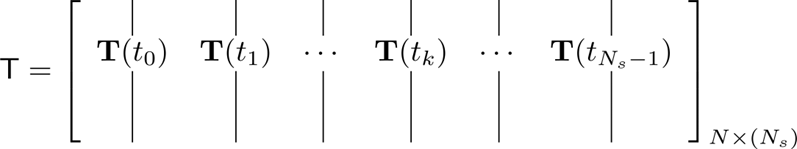

In [10]:
# Create DMD object and start the timer
dmd_training_timer.Start()

# Initialize DMD object with the size of the initial condition and time step
dmd_u = algo.DMD(len(u_array[0]), dt)

# Stop the timer for DMD training initialization
dmd_training_timer.Stop()

for u in u_array:
    dmd_training_timer.Start()
    # Take a sample of the current state for DMD training
    dmd_u.takeSample(u, t)
    dmd_training_timer.Stop()
    
    ts += [t]  # Update the time steps
    t = t + dt  # Increment time

#### Calculate the DMD modes.

In [11]:
if (myid == 0 and rdim != -1 and ef != -1):
    print("Both rdim and ef are set. ef will be ignored.")

# Start the timer for DMD training
dmd_training_timer.Start()

if (rdim != -1):
    if (myid == 0):
        print("Creating DMD with rdim: %d" % rdim)
    dmd_u.train(rdim)
elif (ef != -1):
    if (myid == 0):
        print("Creating DMD with energy fraction:", ef)
    dmd_u.train(ef)

# Stop the timer for DMD training
dmd_training_timer.Stop()

Creating DMD with energy fraction: 0.9999
Using 8 basis vectors out of 100.


#### Predict the state at t_final using DMD.

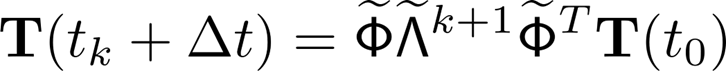

In [12]:
# Start the timer for DMD prediction
dmd_prediction_timer.Start()

result_u = dmd_u.predict(t_final)

# Stop the timer for DMD prediction
dmd_prediction_timer.Stop()

# 15. Calculate the relative error between the DMD final solution and the true solution.
dmd_solution_u = mfem.Vector(result_u.getData(), result_u.dim()) 

# Get the corresponding true solution from u_array
true_solution_u = mfem.Vector(u_array[-1],len(u_array[-1]))

# Calculate the difference between the predicted and true solutions
diff_u = mfem.Vector(true_solution_u.Size())
mfem.subtract_vector(dmd_solution_u, true_solution_u, diff_u)

# Calculate the norms of the difference and true solutions
tot_diff_norm_u = sqrt(mfem.InnerProduct(MPI.COMM_WORLD, diff_u, diff_u))
tot_true_solution_u_norm = sqrt(mfem.InnerProduct(MPI.COMM_WORLD, true_solution_u, true_solution_u))

if (myid == 0):
    print("Relative error of DMD temperature (u) at t_final: %f is %f" % (t_final, tot_diff_norm_u / tot_true_solution_u_norm))

    print("Elapsed time for predicting DMD: %e second" % dmd_prediction_timer.duration)

Relative error of DMD temperature (u) at t_final: 0.500000 is 0.000014
Elapsed time for predicting DMD: 1.051593e-02 second


In [13]:
# Create ParaView data collection and set up parameters
paraview_dc = mfem.ParaViewDataCollection(f"Heat_Conduction", pmesh)
paraview_dc.SetPrefixPath(data_dir+"ParaView_dmd")
paraview_dc.SetLevelsOfDetail(8)
paraview_dc.SetCycle(0)
paraview_dc.SetTime(0.0)
paraview_dc.SetDataFormat(mfem.VTKFormat_BINARY)
paraview_dc.SetHighOrderOutput(True)
paraview_dc.RegisterField("solution", u_gf)
paraview_dc.Save()

u_dmd = []

for i, tsi in enumerate(ts):
        result_u = dmd_u.predict(tsi)
        u_dmd.append(result_u)
        dmd_solution_u = mfem.Vector(result_u.getData(), result_u.dim())
        u_gf.SetFromTrueDofs(dmd_solution_u)
        paraview_dc.SetCycle(i)
        paraview_dc.SetTime(tsi)
        paraview_dc.Save()
       
        del result_u

#### Free the used memory.

In [14]:
MPI.Finalize()